# Simulation of a prism applied to a Non-linear inverse problem using Genetic Algorithm Method

## Importing libraries

In [1]:
%matplotlib inline
from fatiando.gridder import regular, spacing
from fatiando.mesher import Prism
from fatiando.utils import ang2vec
from fatiando.gravmag import prism
from fatiando.constants import CM, T2NT
import numpy as np
import matplotlib.pyplot as plt
from visual import histeq

## Prism parameters

### Dimension of the prism

In [2]:
dimx = 5.  # in mm
dimy = 5.
dimz = 5.

In [3]:
Lx = 1e-3*dimx

In [4]:
Ly = 1e-3*dimy

In [5]:
Lz = 1e-3*dimz

### Sensor-to-sample distance

In [6]:
voo = 500.
dist = voo*1e-6
sts = dist + (0.5*Lz) 

## Parameters for the observation coordinate

In [7]:
Nx = 50
Ny = 50
shape = (Nx,Ny)

In [8]:
xmax = 1e-3*6.
xmin = -xmax
ymax = 1e-3*6.
ymin = -ymax

area = [xmin,xmax,ymin,ymax]

In [9]:
x,y,z = regular(area,shape, -sts)

## Generating the sample

In [10]:
intensity = 0.1
inclination = 90.
declination = 0.

In [11]:
mag = ang2vec(intensity,inclination,declination)

In [12]:
sample = [Prism(-0.5*Lx,0.5*Lx,-0.5*Ly,0.5*Ly,-0.5*Lz,0.5*Lz, props={'magnetization': mag})]

## True parameters

In [13]:
p_true = np.array([voo,intensity]) ## (sensor-to-sample,intensity)

## Calculating the observed data

In [14]:
Bz = prism.bz(x,y,z,sample)

In [15]:
np.random.seed(seed=40)

std_noise = 0.02*np.max(np.abs(Bz))

r = np.random.normal(0.0, std_noise, Nx*Ny)

print '%.3f nT' % std_noise

0.896 nT


In [16]:
Bz_obs = Bz + r

## Calculating the predicted data

In [17]:
def pred_data(x,y,p,sample,inc,dec):
    '''
    Calculate the predicted data.
    '''
    voo = p[0]
    dist = voo*1e-6
    sts = dist + (0.5*Lz) 
    z = -sts*np.ones_like(x)
    
    m = p[1]
    jx = np.cos(np.deg2rad(inc))*np.cos(np.deg2rad(dec))
    jy = np.cos(np.deg2rad(inc))*np.sin(np.deg2rad(dec))
    jz = np.sin(np.deg2rad(inc))
    bz = prism.kernelxz(x,y,z,sample[0])*jx+\
         prism.kernelyz(x,y,z,sample[0])*jy+\
         prism.kernelzz(x,y,z,sample[0])*jz
    bz *= CM*T2NT*m
    return  bz

## Observed data and predicted data

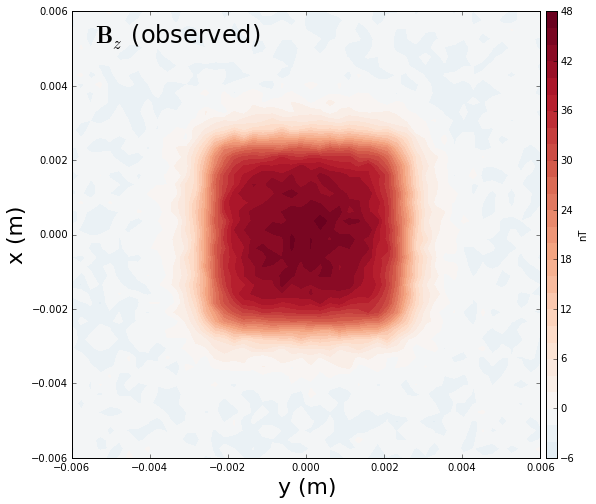

In [18]:
title_font = 22
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(10,8))

ranges = saturation_factor*np.abs([Bz_obs.max(), Bz_obs.min()]).max()

plt.contourf(y.reshape(shape), x.reshape(shape), Bz_obs.reshape(shape),30, cmap=plt.cm.RdBu_r, vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.annotate('$\mathbf{B}_z$ (observed)', xy = (0.05, 0.93), 
             xycoords = 'axes fraction', fontsize=24)

plt.show()

## Visualization of the data misfit

In [19]:
Nm = 20
m_range = np.linspace(0.01,.2,num=Nm)

In [20]:
Nh = 20
h_range = np.linspace(10.,1000.,num=Nh)

In [21]:
h_range,m_range = np.meshgrid(h_range,m_range)

In [22]:
shape_phi = (Nh,Nm)

In [23]:
misfit = []
for mi,hi in zip (m_range.ravel(),h_range.ravel()):
    p = np.array([hi,mi])
    Bz_pred_it = pred_data(x,y,p,sample,inclination,declination)
    res = Bz_obs - Bz_pred_it 
    misfit.append(np.linalg.norm(res))

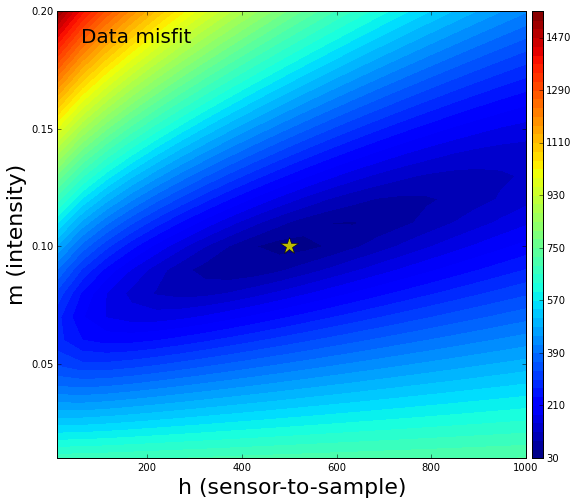

In [24]:
title_font = 22
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(10,8))
plt.contourf(h_range, m_range, np.array(misfit).reshape(shape_phi), 50)
plt.plot(voo,intensity,'y*',markersize=18)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
plt.xlabel('h (sensor-to-sample)', fontsize = title_font)
plt.ylabel('m (intensity)', fontsize = title_font)
plt.annotate('Data misfit', xy = (0.05, 0.93), xycoords = 'axes fraction', fontsize=20)

plt.show()

## Calculating the Simulated Anealling method for the prism

### Functions for Genetic Algorithm

In [25]:
def function(n,p,B_obs,x,y,sample,inc,dec):
    '''
    Calcula o valor da funcao para uma determinada populacao.
    '''
    phi = np.zeros(n)

    for j, pop in enumerate(p):
        B = pred_data(x,y,pop,sample,inc,dec)
        r = Bz_obs - B
        phi[j] = np.linalg.norm(r)
        
    return phi

In [26]:
def fitness(phi):
    '''
    Calcula a aptidao de cada um dos n individuos que compoem uma populacao.
    
    input 
    
    f : array - funcao calculada para cada um dos individuos.
    
    return
    
    s : array - aptidao calculada para cada um dos individuos.
    '''
    
    s = 1./(1. + abs(phi))
    s /= np.sum(s)
    
    return s

In [27]:
def crossover(n, g, p, s):
    '''
    Funcao que faz o cruzamento entre individuos da populacao
    
    input
    
    n: integer - numero de individuos que compoem a populacao
    g: integer - numero de genes 
    p: array - array com os individos que compoem a populacao
    s: array - array que contem a aptidao de cada um dos individuos
    
    return
    
    pf: array - array que contem os filhos
    
    '''
    i_p = []
    i_m = []
    for i in range(n):
        ip, im = np.random.choice(np.arange(n), size=g, replace=False, p=s)
        i_p.append(ip)
        i_m.append(im)
       
    pf = np.empty((n,g),dtype=float)
    pf[:, 0] = (p[i_p, 0]*s[i_p] + p[i_m, 0]*s[i_m])/(s[i_p] + s[i_m])
    pf[:, 1] = (p[i_p, 1]*s[i_p] + p[i_m, 1]*s[i_m])/(s[i_p] + s[i_m])    
    
    return pf

In [28]:
def mutation(n,g,p):
    '''
    Funcao que faz a mutacao de algum gene em algum individuo da populacao
    
    input
    
    n: integer - numero de individuos que compoem a populacao
    g: integer - numero de genes 
    p: array - array com os individos que compoem a populacao
        
    return
    
    pf: array - array que contem os filhos
    
    '''
    prob = 0.1
    for i in range(n):
        rand = np.random.rand()
        if rand <= prob:
            j_mutation = np.random.choice(np.arange(g))
            p[i,j_mutation] += (np.random.uniform(low=-.00001, high=.00001, size=None))
    return p

In [29]:
def elitism(n,nr,g, p_pai, p_filho):
    '''
    Seleciona os melhores individuos entre uma população de pais e filhos.
    
    input
    
    n: integer - numero total de individuos.
    nr: integer - numero de filhos que serao replicados
    p_pai: array - populacao de pais
    p_filho: array - populacao de filhos
    
    return
    
    p_new : array - população nova
    '''
    p_tot = np.vstack((p_pai, p_filho))
    phi_tot = function(n,p_tot)
    i_sort = np.argsort(phi_tot)
    
    i_bad = i_sort[-nr:]
    i_best = i_sort[:nr]
    
    p_bad = np.empty((nr,g))
    p_best = np.empty((nr,g))
    for i in range(nr):
        p_bad[i] = p_tot[i_bad[i]]
        p_best[i] = p_tot[i_best[i]]
    
    p_red = np.delete(p_tot,p_bad).reshape(n-nr,g)
    p_new = np.vstack((p_best,p_red))        
    return p_new

### Initial parameters for the algorithm

In [30]:
itmax = 100

In [31]:
g = 2
n = 30
nr = 3

p0 = np.empty((n,g))
for i in range(n):
    p0[i,0] = np.random.uniform(low=80., high=700., size=None)
    p0[i,1] = np.random.uniform(low= 0.05, high=.2, size=None)

In [32]:
phi0 = function(n,p0,Bz_obs,x,y,sample,inclination,declination) # function phi 

In [33]:
s0 = fitness(phi0) # function for aptidao

In [34]:
i_best = np.argmax(s0)

In [35]:
# List for phi and p0

px = [p0[i_best,0]]
py = [p0[i_best,1]]
phi_it = [phi0[i_best]]

### Genetic Algorithm

In [36]:
for i in range(itmax):
    p_new = crossover(n,g,p0,s0)
    p = mutation(n,g,p_new)
    #p = elitism(n,nr,g,p0,p)
    phi = function(n,p,Bz_obs,x,y,sample,inclination,declination)
    s = fitness(phi)
    i_best = np.argmax(s)
    
    phi0 = phi
    p0 = p
    s0 = s
     
    px.append(p0[i_best,0])
    py.append(p0[i_best,1])
    phi_it.append(phi0[i_best])

In [37]:
print p0[i_best]

[  4.66691271e+02   9.73379643e-02]


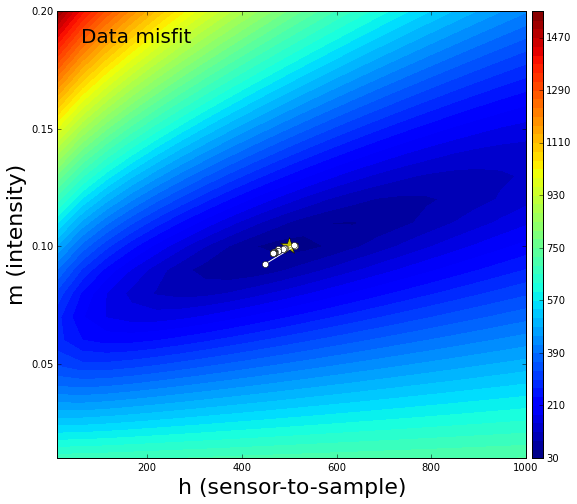

In [38]:
title_font = 22
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(10,8))
plt.contourf(h_range, m_range, np.array(misfit).reshape(shape_phi), 50)
plt.plot(voo,intensity,'y*',markersize=18)
plt.plot(px,py,'wo-')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
plt.xlabel('h (sensor-to-sample)', fontsize = title_font)
plt.ylabel('m (intensity)', fontsize = title_font)
plt.annotate('Data misfit', xy = (0.05, 0.93), xycoords = 'axes fraction', fontsize=20)

plt.show()

## Plotting misfit

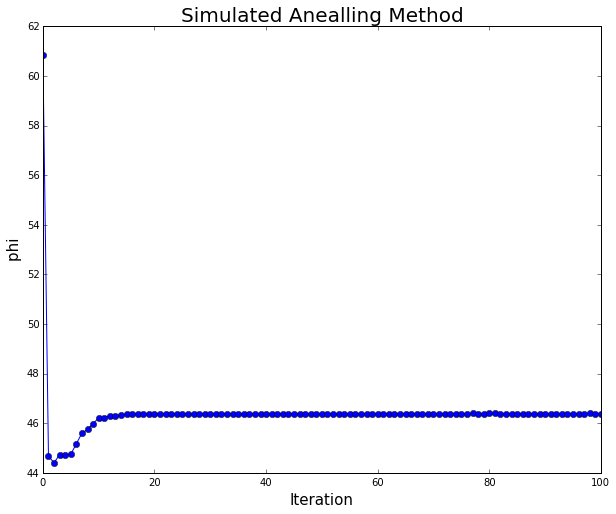

In [39]:
plt.figure(figsize=(10,8))

plt.plot(phi_it, 'o-')
plt.title('Simulated Anealling Method',fontsize=20)
plt.ylabel('phi ',fontsize=15)
plt.xlabel('Iteration',fontsize=15)

plt.show()


## Data Fitting 

In [40]:
Bz_calc = pred_data(x,y,p0[i_best],sample,inclination,declination)

In [41]:
res = Bz_obs - Bz_calc

In [42]:
r_mean = np.mean(res)
r_std = np.std(res)
r_norm = (res - r_mean)/r_std

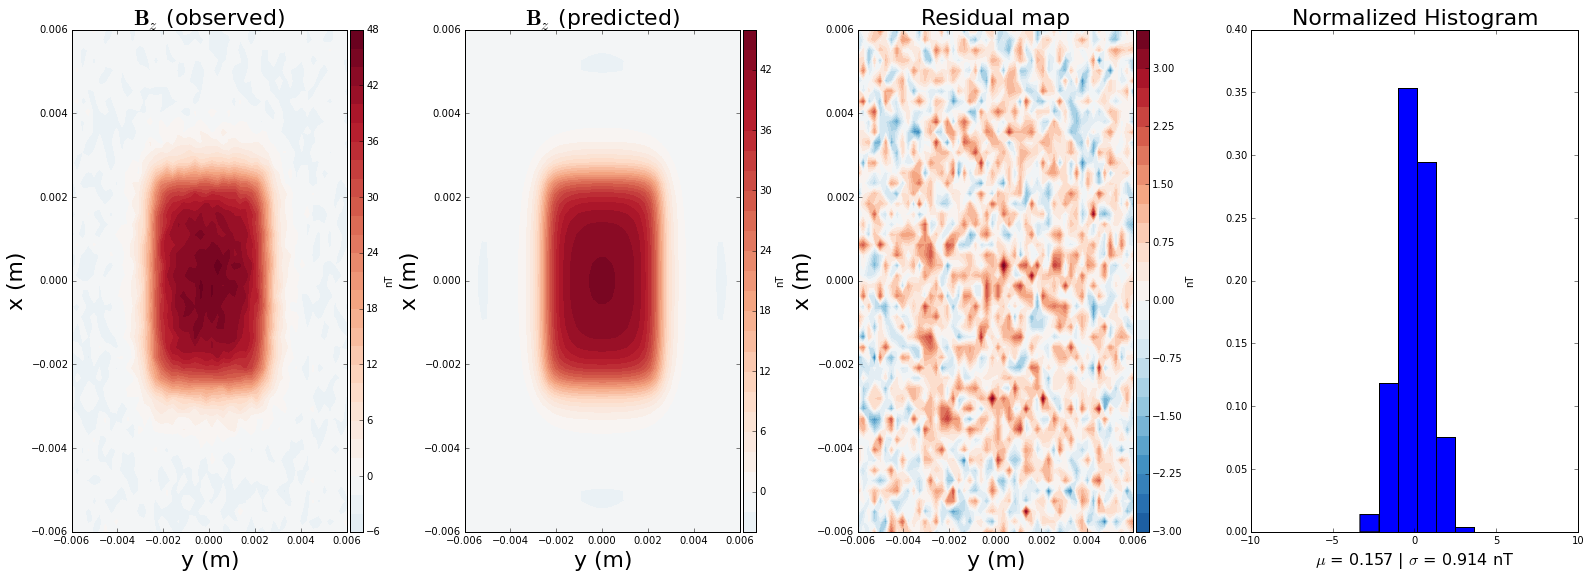

In [43]:
title_font = 22
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(27,9))

ranges = saturation_factor*np.abs([Bz_obs.max(), Bz_obs.min()]).max()

plt.subplot(1,4,1)

plt.contourf(y.reshape(shape), x.reshape(shape), Bz_obs.reshape(shape),30, cmap=plt.cm.RdBu_r, vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('$\mathbf{B}_z$ (observed)',fontsize=title_font)

plt.subplot(1,4,2)

plt.contourf(y.reshape(shape), x.reshape(shape), Bz_calc.reshape(shape), 30, cmap=plt.cm.RdBu_r, vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('$\mathbf{B}_z$ (predicted)', fontsize=title_font)

plt.subplot(1,4,3)
ranges = saturation_factor*np.abs([res.max(), res.min()]).max()

plt.contourf(y.reshape(shape), x.reshape(shape), res.reshape(shape), 30, cmap=plt.cm.RdBu_r, vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('Residual map', fontsize=title_font)

plt.subplot(1,4,4)
plt.title('Normalized Histogram', fontsize=title_font)
plt.xlabel('$\mu$ = %.3f | $\sigma$ = %.3f nT' % (r_mean, r_std), fontsize = bottom_font)
nbins = int((np.max(r_norm) - np.min(r_norm)))
plt.hist(r_norm,bins=nbins,normed=True)
plt.ylim(0.,0.4)
plt.xlim(-10., 10.)



plt.show()